In [1]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
import torch

import matplotlib.pyplot as plt

from dlp.dataset import Dataset

from parksim.intent_predict.cnn.data_processing.utils import CNNDataProcessor
from parksim.trajectory_predict.data_processing.utils import TransformerDataProcessor

from parksim.intent_predict.cnn.models.small_regularized_cnn import SmallRegularizedCNN
from parksim.trajectory_predict.intent_transformer.models.trajectory_predictor_vision_transformer import TrajectoryPredictorVisionTransformer
from parksim.trajectory_predict.intent_transformer.models.trajectory_predictor_with_decoder_intent_cross_attention import TrajectoryPredictorWithDecoderIntentCrossAttention

from parksim.trajectory_predict.intent_transformer.multimodal_prediction import predict_multimodal

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
ds = Dataset()

home_path = str(Path.home()) 
ds.load(home_path + '/dlp-dataset/data/DJI_0012')

In [3]:
MODEL_PATH = r'checkpoints/TrajectoryPredictorWithDecoderIntentCrossAttention/lightning_logs/version_1/checkpoints/epoch=52-val_total_loss=0.0458.ckpt'
traj_model = TrajectoryPredictorWithDecoderIntentCrossAttention.load_from_checkpoint(MODEL_PATH)
traj_model.eval().to(DEVICE)
mode='v1'

INTENT_MODEL_PATH = r'models/smallRegularizedCNN_L0.068_01-29-2022_19-50-35.pth'
intent_model = SmallRegularizedCNN()
model_state = torch.load(INTENT_MODEL_PATH, map_location=DEVICE)
intent_model.load_state_dict(model_state)
intent_model.eval().to(DEVICE)

SmallRegularizedCNN(
  (image_layer): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 8, kernel_size=(7, 7), stride=(1, 1))
      (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Dropout(p=0.2, inplace=False)
      (3): LeakyReLU(negative_slope=0.01, inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv2d(8, 8, kernel_size=(5, 5), stride=(1, 1))
      (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Dropout(p=0.2, inplace=False)
      (3): LeakyReLU(negative_slope=0.01, inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): Sequential(
      (0): Conv2d(8, 3, kernel_size=(3, 3), stride=(1, 1))
      (1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Dropout(p=0.2, inplace=False)
      (3): LeakyReLU(

In [4]:
intent_extractor = CNNDataProcessor(ds=ds)
traj_extractor = TransformerDataProcessor(ds=ds)

In [5]:
def draw_prediction(multimodal_prediction, inst_centric_view, colors, intent_offsets):
    sensing_limit = 20
    img_size = inst_centric_view.size[0] / 2

    plt.cla()

    plt.imshow(inst_centric_view)

    y_label, _, _, _ = multimodal_prediction[0]

    traj_future_pixel = y_label[0, :, :2].detach().cpu().numpy() / \
        sensing_limit*img_size + img_size

    plt.plot(traj_future_pixel[:, 0], traj_future_pixel[:, 1], 'wo', linewidth=2, markersize=2)

    for prediction, color, offset in zip(reversed(multimodal_prediction), reversed(colors), reversed(intent_offsets)):

        _, pred, intent, probability = prediction

        intent_pixel = intent[0, 0, :2].detach().cpu().numpy() / \
            sensing_limit*img_size + img_size

        traj_pred_pixel = pred[0, :, :2].detach().cpu().numpy() / \
            sensing_limit*img_size + img_size

        plt.plot(traj_pred_pixel[:, 0], traj_pred_pixel[:, 1],
                 '^', color=color, linewidth=2, markersize=2)
        plt.plot(intent_pixel[0], intent_pixel[1],
                 '*', color=color, markersize=8)

        plt.text(intent_pixel[0]+offset[0], intent_pixel[1]+offset[1],
                 f'{probability:.2f}', backgroundcolor=(170/255., 170/255., 170/255., 0.53), color='black', size=7, weight='bold')
        print(color, probability)
                 
    plt.axis('off')


# Example 1

In [6]:
scene = ds.get('scene', ds.list_scenes()[0])
frame_index = 80
frame = ds.get_future_frames(scene['first_frame'],timesteps=300)[frame_index]
inst_token = frame['instances'][1]

In [16]:
multimodal_prediction, inst_centric_view = predict_multimodal(
    ds, traj_model, intent_model, traj_extractor, intent_extractor, inst_token, frame_index, 3, mode=mode)


torch.Size([1, 10, 3])
torch.Size([1, 1, 3])
torch.Size([1, 1, 3])
torch.Size([1, 10, 3])
torch.Size([1, 1, 3])
torch.Size([1, 1, 3])
torch.Size([1, 10, 3])
torch.Size([1, 1, 3])
torch.Size([1, 1, 3])


green 0.12416810790697733
C1 0.2235025942325592
darkviolet 0.5509269


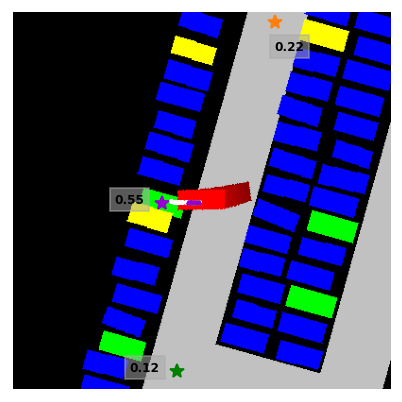

In [8]:
colors = ['darkviolet', 'C1', 'green']
intent_offsets = [[-50,0], [0,30], [-50,0]]

draw_prediction(multimodal_prediction, inst_centric_view,
                colors, intent_offsets)


# Example 2

In [6]:
scene = ds.get('scene', ds.list_scenes()[0])
frame_index = 2500
frame = ds.get_future_frames(scene['first_frame'], timesteps=2700)[frame_index]
inst_token = frame['instances'][33]


In [41]:
multimodal_prediction, inst_centric_view = predict_multimodal(
    ds, traj_model, intent_model, traj_extractor, intent_extractor, inst_token, frame_index, 3, mode=mode)


tensor([[[-10.5934,   0.8883,  -0.0992],
         [ -9.2064,   0.7964,  -0.0802],
         [ -7.8301,   0.6954,  -0.0776],
         [ -6.5365,   0.5603,  -0.0927],
         [ -5.2858,   0.3882,  -0.1165],
         [ -4.0863,   0.1998,  -0.1345],
         [ -2.9553,   0.0365,  -0.1376],
         [ -1.8903,  -0.0717,  -0.1205],
         [ -0.8894,  -0.0951,  -0.0764],
         [  0.0000,   0.0000,   0.0000]]], device='cuda:0') tensor([[[1.6958, 0.2598, 0.1413]]], device='cuda:0')
tensor([[[-10.5934,   0.8883,  -0.0992],
         [ -9.2064,   0.7964,  -0.0802],
         [ -7.8301,   0.6954,  -0.0776],
         [ -6.5365,   0.5603,  -0.0927],
         [ -5.2858,   0.3882,  -0.1165],
         [ -4.0863,   0.1998,  -0.1345],
         [ -2.9553,   0.0365,  -0.1376],
         [ -1.8903,  -0.0717,  -0.1205],
         [ -0.8894,  -0.0951,  -0.0764],
         [  0.0000,   0.0000,   0.0000]]], device='cuda:0') tensor([[[2.4213, 0.4679, 0.2072]]], device='cuda:0')
tensor([[[-10.5934,   0.8883,  -0.

In [37]:
print(multimodal_prediction[2][1])
# each index of multimodal_prediction is a possible path
# it contains label (true future trajectory, same for each possible path), input, intent (position you are going to relative to current position), probability
# label is [x, y, heading] all relative to current position

tensor([[[0.8894, 0.0951, 0.0764],
         [1.7010, 0.2817, 0.1511],
         [2.4294, 0.5347, 0.2349],
         [3.1057, 0.8588, 0.3264],
         [3.7308, 1.2473, 0.4210],
         [4.3034, 1.6895, 0.5134],
         [4.8171, 2.1668, 0.5969],
         [5.2724, 2.6600, 0.6671],
         [5.6767, 3.1554, 0.7224],
         [6.0410, 3.6416, 0.7627]]], device='cuda:0')


green 0.13618724
C1 0.17413229
darkviolet 0.19189231395721437


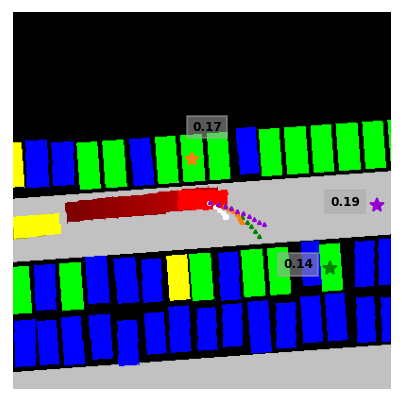

In [21]:
colors = ['darkviolet', 'C1', 'green']
intent_offsets = [[-50, 0], [0, -30], [-50, 0]]

draw_prediction(multimodal_prediction, inst_centric_view,
                colors, intent_offsets)


# Example 3

In [13]:
scene = ds.get('scene', ds.list_scenes()[0])
frame_index = 5900
frame = ds.get_future_frames(scene['first_frame'], timesteps=6000)[frame_index]
inst_token = frame['instances'][37]


In [14]:
multimodal_prediction, inst_centric_view = predict_multimodal(
    ds, traj_model, intent_model, traj_extractor, intent_extractor, inst_token, frame_index, 3, mode=mode)


green 0.10004076
C1 0.11806229352951049
darkviolet 0.17509556


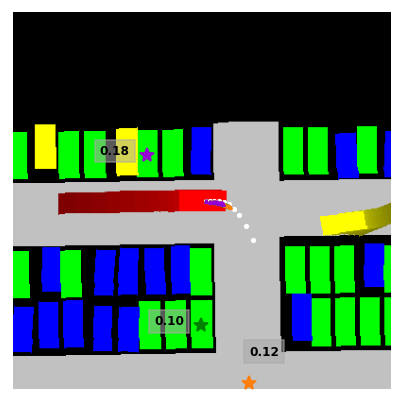

In [15]:
colors = ['darkviolet', 'C1', 'green']
intent_offsets = [[-50, 0], [0, -30], [-50, 0]]

draw_prediction(multimodal_prediction, inst_centric_view,
                colors, intent_offsets)


# Example 4

In [16]:
scene = ds.get('scene', ds.list_scenes()[0])
frame_index = 4000
frame = ds.get_future_frames(scene['first_frame'], timesteps=6000)[frame_index]
inst_token = frame['instances'][36]


In [17]:
multimodal_prediction, inst_centric_view = predict_multimodal(
    ds, traj_model, intent_model, traj_extractor, intent_extractor, inst_token, frame_index, 3, mode=mode)


green 0.16417675
C1 0.19649439
darkviolet 0.20022014379501343


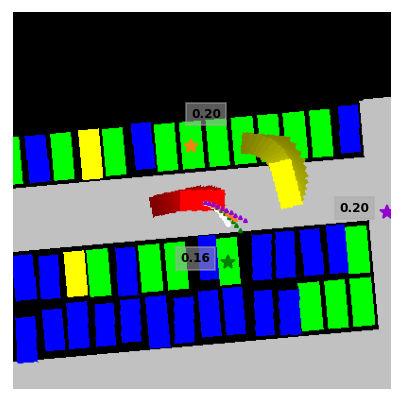

In [18]:
colors = ['darkviolet', 'C1', 'green']
intent_offsets = [[-50, 0], [0, -30], [-50, 0]]

draw_prediction(multimodal_prediction, inst_centric_view,
                colors, intent_offsets)


# Example 5

In [19]:
scene = ds.get('scene', ds.list_scenes()[0])
frame_index = 100
frame = ds.get_future_frames(scene['first_frame'], timesteps=6000)[frame_index]
inst_token = frame['instances'][6]


In [20]:
multimodal_prediction, inst_centric_view = predict_multimodal(
    ds, traj_model, intent_model, traj_extractor, intent_extractor, inst_token, frame_index, 3, mode=mode)


green 0.06666666666666667
C1 0.3333333333333333
darkviolet 0.6


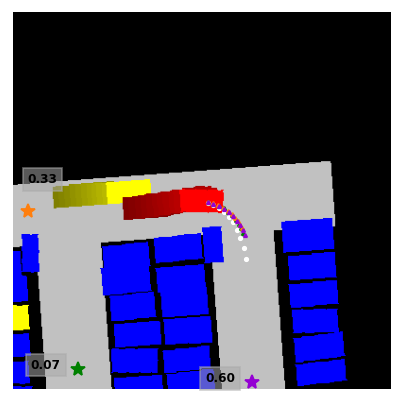

In [21]:
colors = ['darkviolet', 'C1', 'green']
intent_offsets = [[-50, 0], [0, -30], [-50, 0]]

draw_prediction(multimodal_prediction, inst_centric_view,
                colors, intent_offsets)


# Example 6

In [25]:
scene = ds.get('scene', ds.list_scenes()[0])
frame_index = 1800
frame = ds.get_future_frames(scene['first_frame'], timesteps=6000)[frame_index]
# inst_token = frame['instances'][6]
inst_token = ds.get_inst_at_location(frame_token=frame['frame_token'], coords=[70, 30])[
    'instance_token']


In [26]:
multimodal_prediction, inst_centric_view = predict_multimodal(
    ds, traj_model, intent_model, traj_extractor, intent_extractor, inst_token, frame_index, 3, mode=mode)


green 0.14739163
C1 0.19268943071365355
darkviolet 0.28882438


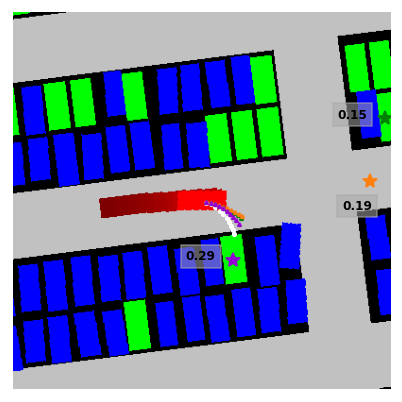

In [27]:
colors = ['darkviolet', 'C1', 'green']
intent_offsets = [[-50, 0], [-30, 30], [-50, 0]]

draw_prediction(multimodal_prediction, inst_centric_view,
                colors, intent_offsets)


# Example 7

In [43]:
scene = ds.get('scene', ds.list_scenes()[0])
frame_index = 7010
frame = ds.get_future_frames(scene['first_frame'], timesteps=7100)[frame_index]
# inst_token = frame['instances'][6]
inst_token = ds.get_inst_at_location(frame_token=frame['frame_token'], coords=[15, 30])[
    'instance_token']


In [44]:
multimodal_prediction, inst_centric_view = predict_multimodal(
    ds, traj_model, intent_model, traj_extractor, intent_extractor, inst_token, frame_index, 3, mode=mode)


green 0.0965719719727834
C1 0.17382954955101013
darkviolet 0.7088469


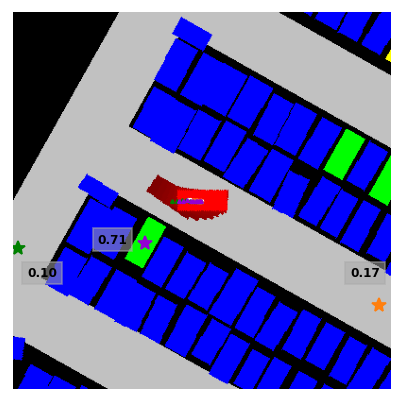

In [45]:
colors = ['darkviolet', 'C1', 'green']
intent_offsets = [[-50, 0], [-30, -30], [10, 30]]

draw_prediction(multimodal_prediction, inst_centric_view,
                colors, intent_offsets)


# Example 8

In [46]:
scene = ds.get('scene', ds.list_scenes()[0])
frame_index = 9000
frame = ds.get_future_frames(scene['first_frame'], timesteps=9001)[frame_index]
# inst_token = frame['instances'][6]
inst_token = ds.get_inst_at_location(frame_token=frame['frame_token'], coords=[35, 65])[
    'instance_token']


In [47]:
multimodal_prediction, inst_centric_view = predict_multimodal(
    ds, traj_model, intent_model, traj_extractor, intent_extractor, inst_token, frame_index, 3, mode=mode)


green 0.09163544575373331
C1 0.16494380235671996
darkviolet 0.7214014


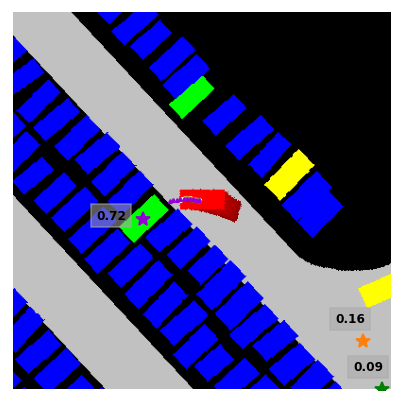

In [48]:
colors = ['darkviolet', 'C1', 'green']
intent_offsets = [[-50, 0], [-30, -20], [-30, -20]]

draw_prediction(multimodal_prediction, inst_centric_view,
                colors, intent_offsets)
